In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      input_shape=input_shape))
    model.add(Activation('tanh'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same'))
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(Activation('tanh'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_44 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_74 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0494 - acc: 0.3454
Epoch 00001: val_loss improved from inf to 1.68682, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_3_conv_checkpoint/001-1.6868.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.0494 - acc: 0.3454 - val_loss: 1.6868 - val_acc: 0.4447
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5249 - acc: 0.5171
Epoch 00002: val_loss improved from 1.68682 to 1.49431, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_3_conv_checkpoint/002-1.4943.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.5248 - acc: 0.5171 - val_loss: 1.4943 - val_acc: 0.5311
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3214 - acc: 0.5831
Epoch 00003: val_loss improved from 1

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2599 - acc: 0.9157
Epoch 00027: val_loss did not improve from 1.34829
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2598 - acc: 0.9157 - val_loss: 1.4683 - val_acc: 0.6580
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2585 - acc: 0.9162
Epoch 00028: val_loss did not improve from 1.34829
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2585 - acc: 0.9162 - val_loss: 1.4793 - val_acc: 0.6564
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2451 - acc: 0.9207
Epoch 00029: val_loss did not improve from 1.34829
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2451 - acc: 0.9207 - val_loss: 1.4939 - val_acc: 0.6494
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2366 - acc: 0.9234
Epoch 00030: val_loss did not improve from 1.34829
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9585
Epoch 00057: val_loss did not improve from 1.34829
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1299 - acc: 0.9585 - val_loss: 1.6890 - val_acc: 0.6778
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1209 - acc: 0.9620
Epoch 00058: val_loss did not improve from 1.34829
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1209 - acc: 0.9620 - val_loss: 1.7114 - val_acc: 0.6813
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1270 - acc: 0.9594
Epoch 00059: val_loss did not improve from 1.34829
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1270 - acc: 0.9594 - val_loss: 1.6602 - val_acc: 0.6834
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1208 - acc: 0.9611
Epoch 00060: val_loss did not improve from 1.34829
36805/36805 [===========

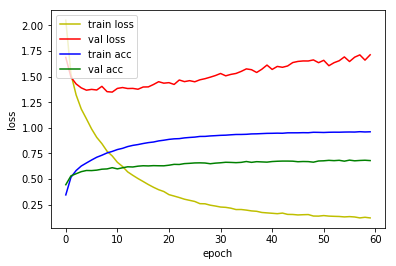

4815/4815 [==============================] - 4s 904us/sample - loss: 1.4452 - acc: 0.5736
Loss: 1.4451579620781223 Accuracy: 0.5736241

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9469 - acc: 0.3704
Epoch 00001: val_loss improved from inf to 1.48889, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_4_conv_checkpoint/001-1.4889.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.9468 - acc: 0.3704 - val_loss: 1.4889 - val_acc: 0.5532
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4218 - acc: 0.5519
Epoch 00002: val_loss improved from 1.48889 to 1.24301, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_4_conv_checkpoint/002-1.2430.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.4218 - acc: 0.5519 - val_loss: 1.2430 - val_acc: 0.6303
Epoch 3/500
36800/36805 [====================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4407 - acc: 0.8599
Epoch 00024: val_loss did not improve from 0.88727
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.4407 - acc: 0.8599 - val_loss: 0.9017 - val_acc: 0.7510
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4277 - acc: 0.8663
Epoch 00025: val_loss did not improve from 0.88727
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.4277 - acc: 0.8663 - val_loss: 0.8910 - val_acc: 0.7580
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4099 - acc: 0.8719
Epoch 00026: val_loss improved from 0.88727 to 0.88101, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_4_conv_checkpoint/026-0.8810.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.4099 - acc: 0.8719 - val_loss: 0.8810 - val_acc: 0.7594
Epoch 27/500
36800/36805 [============================>.] - 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2388 - acc: 0.9216
Epoch 00053: val_loss did not improve from 0.87705
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2388 - acc: 0.9216 - val_loss: 0.9697 - val_acc: 0.7738
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2355 - acc: 0.9207
Epoch 00054: val_loss did not improve from 0.87705
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2355 - acc: 0.9207 - val_loss: 0.9395 - val_acc: 0.7780
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2293 - acc: 0.9251
Epoch 00055: val_loss did not improve from 0.87705
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2293 - acc: 0.9251 - val_loss: 0.9095 - val_acc: 0.7864
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2301 - acc: 0.9241
Epoch 00056: val_loss did not improve from 0.87705
36805/36805 [===========

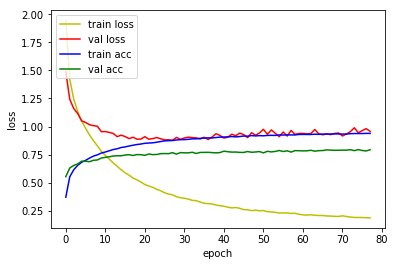

4815/4815 [==============================] - 4s 934us/sample - loss: 0.9308 - acc: 0.7410
Loss: 0.9308356591721809 Accuracy: 0.74101764

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8388 - acc: 0.4055
Epoch 00001: val_loss improved from inf to 1.45153, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_5_conv_checkpoint/001-1.4515.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 1.8389 - acc: 0.4055 - val_loss: 1.4515 - val_acc: 0.5467
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3967 - acc: 0.5630
Epoch 00002: val_loss improved from 1.45153 to 1.20839, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_5_conv_checkpoint/002-1.2084.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.3966 - acc: 0.5630 - val_loss: 1.2084 - val_acc: 0.6380
Epoch 3/500
36800/36805 [===================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5207 - acc: 0.8452
Epoch 00022: val_loss did not improve from 0.70283
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.5207 - acc: 0.8453 - val_loss: 0.7078 - val_acc: 0.7952
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5077 - acc: 0.8492
Epoch 00023: val_loss improved from 0.70283 to 0.68262, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_5_conv_checkpoint/023-0.6826.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.5076 - acc: 0.8492 - val_loss: 0.6826 - val_acc: 0.8006
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4898 - acc: 0.8535
Epoch 00024: val_loss did not improve from 0.68262
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4898 - acc: 0.8535 - val_loss: 0.6985 - val_acc: 0.8004
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2643 - acc: 0.9143
Epoch 00051: val_loss did not improve from 0.65550
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2642 - acc: 0.9144 - val_loss: 0.7009 - val_acc: 0.8162
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2563 - acc: 0.9168
Epoch 00052: val_loss did not improve from 0.65550
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2563 - acc: 0.9168 - val_loss: 0.7354 - val_acc: 0.8104
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2608 - acc: 0.9149
Epoch 00053: val_loss did not improve from 0.65550
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2608 - acc: 0.9149 - val_loss: 0.7062 - val_acc: 0.8181
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2520 - acc: 0.9193
Epoch 00054: val_loss did not improve from 0.65550
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1873 - acc: 0.9382
Epoch 00081: val_loss did not improve from 0.65550
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1872 - acc: 0.9382 - val_loss: 0.7699 - val_acc: 0.8123
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9388
Epoch 00082: val_loss did not improve from 0.65550
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1858 - acc: 0.9388 - val_loss: 0.7282 - val_acc: 0.8253
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1874 - acc: 0.9385
Epoch 00083: val_loss did not improve from 0.65550
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1874 - acc: 0.9385 - val_loss: 0.7052 - val_acc: 0.8318
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1834 - acc: 0.9389
Epoch 00084: val_loss did not improve from 0.65550
36805/36805 [===========

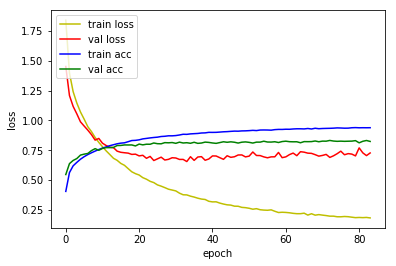

4815/4815 [==============================] - 5s 973us/sample - loss: 0.7363 - acc: 0.7848
Loss: 0.7362892188758493 Accuracy: 0.78483903

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0107 - acc: 0.3380
Epoch 00001: val_loss improved from inf to 1.51269, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_6_conv_checkpoint/001-1.5127.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 2.0106 - acc: 0.3380 - val_loss: 1.5127 - val_acc: 0.5302
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5392 - acc: 0.5048
Epoch 00002: val_loss improved from 1.51269 to 1.24850, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_6_conv_checkpoint/002-1.2485.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.5391 - acc: 0.5048 - val_loss: 1.2485 - val_acc: 0.6385
Epoch 3/500
36800/36805 [===================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5341 - acc: 0.8436
Epoch 00023: val_loss improved from 0.51249 to 0.50594, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_6_conv_checkpoint/023-0.5059.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.5340 - acc: 0.8437 - val_loss: 0.5059 - val_acc: 0.8528
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5216 - acc: 0.8475
Epoch 00024: val_loss improved from 0.50594 to 0.50569, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_6_conv_checkpoint/024-0.5057.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.5216 - acc: 0.8475 - val_loss: 0.5057 - val_acc: 0.8609
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5067 - acc: 0.8505
Epoch 00025: val_loss did not improve from 0.50569
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.5067

36800/36805 [============================>.] - ETA: 0s - loss: 0.3207 - acc: 0.9036
Epoch 00048: val_loss did not improve from 0.41205
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3207 - acc: 0.9036 - val_loss: 0.4249 - val_acc: 0.8838
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3215 - acc: 0.9013
Epoch 00049: val_loss did not improve from 0.41205
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3215 - acc: 0.9013 - val_loss: 0.4183 - val_acc: 0.8838
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3135 - acc: 0.9053
Epoch 00050: val_loss improved from 0.41205 to 0.40533, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_6_conv_checkpoint/050-0.4053.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3135 - acc: 0.9053 - val_loss: 0.4053 - val_acc: 0.8915
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.2047 - acc: 0.9367
Epoch 00076: val_loss did not improve from 0.36306
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2047 - acc: 0.9367 - val_loss: 0.3886 - val_acc: 0.9001
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2062 - acc: 0.9357
Epoch 00077: val_loss did not improve from 0.36306
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2062 - acc: 0.9357 - val_loss: 0.4245 - val_acc: 0.8970
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9395
Epoch 00078: val_loss did not improve from 0.36306
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1940 - acc: 0.9395 - val_loss: 0.4186 - val_acc: 0.8966
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2048 - acc: 0.9344
Epoch 00079: val_loss did not improve from 0.36306
36805/36805 [========================

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9534
Epoch 00106: val_loss did not improve from 0.36306
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1424 - acc: 0.9534 - val_loss: 0.3644 - val_acc: 0.9071
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9545
Epoch 00107: val_loss did not improve from 0.36306
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1424 - acc: 0.9545 - val_loss: 0.3921 - val_acc: 0.9029
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1393 - acc: 0.9535
Epoch 00108: val_loss did not improve from 0.36306
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1393 - acc: 0.9535 - val_loss: 0.3968 - val_acc: 0.9061
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1396 - acc: 0.9551
Epoch 00109: val_loss did not improve from 0.36306
36805/36805 [=======

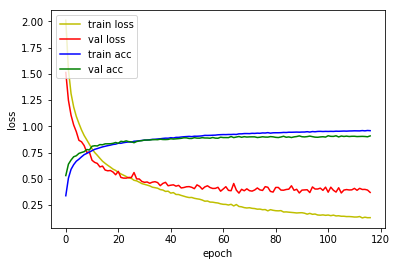

4815/4815 [==============================] - 5s 989us/sample - loss: 0.4636 - acc: 0.8696
Loss: 0.4636152361412286 Accuracy: 0.86957425

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0965 - acc: 0.3146
Epoch 00001: val_loss improved from inf to 1.47757, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_7_conv_checkpoint/001-1.4776.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 2.0964 - acc: 0.3146 - val_loss: 1.4776 - val_acc: 0.5528
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5658 - acc: 0.4996
Epoch 00002: val_loss improved from 1.47757 to 1.22458, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_7_conv_checkpoint/002-1.2246.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.5657 - acc: 0.4996 - val_loss: 1.2246 - val_acc: 0.6364
Epoch 3/500
36800/36805 [===================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3993 - acc: 0.8848
Epoch 00022: val_loss did not improve from 0.34447
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3993 - acc: 0.8848 - val_loss: 0.3489 - val_acc: 0.9061
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3872 - acc: 0.8873
Epoch 00023: val_loss improved from 0.34447 to 0.32240, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_7_conv_checkpoint/023-0.3224.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.3872 - acc: 0.8873 - val_loss: 0.3224 - val_acc: 0.9085
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3724 - acc: 0.8910
Epoch 00024: val_loss did not improve from 0.32240
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3724 - acc: 0.8910 - val_loss: 0.3403 - val_acc: 0.9052
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2179 - acc: 0.9348
Epoch 00049: val_loss did not improve from 0.23071
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2180 - acc: 0.9347 - val_loss: 0.2435 - val_acc: 0.9362
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2087 - acc: 0.9386
Epoch 00050: val_loss did not improve from 0.23071
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2088 - acc: 0.9385 - val_loss: 0.2505 - val_acc: 0.9341
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2124 - acc: 0.9373
Epoch 00051: val_loss did not improve from 0.23071
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2124 - acc: 0.9373 - val_loss: 0.2393 - val_acc: 0.9422
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2000 - acc: 0.9401
Epoch 00052: val_loss did not improve from 0.23071
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1282 - acc: 0.9611
Epoch 00076: val_loss did not improve from 0.20628
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1282 - acc: 0.9611 - val_loss: 0.2372 - val_acc: 0.9415
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1256 - acc: 0.9610
Epoch 00077: val_loss did not improve from 0.20628
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1256 - acc: 0.9610 - val_loss: 0.2237 - val_acc: 0.9441
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9620
Epoch 00078: val_loss did not improve from 0.20628
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1217 - acc: 0.9620 - val_loss: 0.2512 - val_acc: 0.9425
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1200 - acc: 0.9615
Epoch 00079: val_loss did not improve from 0.20628
36805/36805 [========================

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9777
Epoch 00106: val_loss did not improve from 0.20628
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0719 - acc: 0.9777 - val_loss: 0.2418 - val_acc: 0.9462
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9782
Epoch 00107: val_loss did not improve from 0.20628
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0692 - acc: 0.9782 - val_loss: 0.2372 - val_acc: 0.9476
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0768 - acc: 0.9756
Epoch 00108: val_loss did not improve from 0.20628
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0768 - acc: 0.9756 - val_loss: 0.2489 - val_acc: 0.9448
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0740 - acc: 0.9766
Epoch 00109: val_loss did not improve from 0.20628
36805/36805 [=======

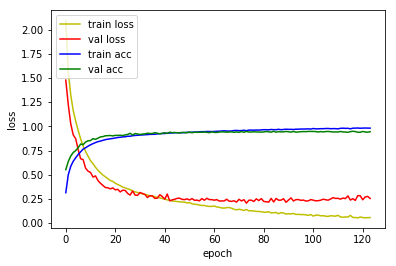

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2361 - acc: 0.9304
Loss: 0.23610414765148519 Accuracy: 0.93042576

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1512 - acc: 0.2995
Epoch 00001: val_loss improved from inf to 1.54326, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_8_conv_checkpoint/001-1.5433.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 2.1512 - acc: 0.2995 - val_loss: 1.5433 - val_acc: 0.5260
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5826 - acc: 0.4929
Epoch 00002: val_loss improved from 1.54326 to 1.15795, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_8_conv_checkpoint/002-1.1580.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.5825 - acc: 0.4929 - val_loss: 1.1580 - val_acc: 0.6695
Epoch 3/500
36800/36805 [===================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2404 - acc: 0.9298
Epoch 00023: val_loss did not improve from 0.18619
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2403 - acc: 0.9298 - val_loss: 0.1894 - val_acc: 0.9476
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2375 - acc: 0.9309
Epoch 00024: val_loss did not improve from 0.18619
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2375 - acc: 0.9309 - val_loss: 0.1941 - val_acc: 0.9460
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2269 - acc: 0.9336
Epoch 00025: val_loss did not improve from 0.18619
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2269 - acc: 0.9337 - val_loss: 0.1937 - val_acc: 0.9485
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2179 - acc: 0.9361
Epoch 00026: val_loss improved from 0.18619 to 0.18553, saving model to mod

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9664
Epoch 00049: val_loss did not improve from 0.15312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1088 - acc: 0.9664 - val_loss: 0.1714 - val_acc: 0.9511
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1061 - acc: 0.9680
Epoch 00050: val_loss did not improve from 0.15312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1061 - acc: 0.9680 - val_loss: 0.1841 - val_acc: 0.9502
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1021 - acc: 0.9682
Epoch 00051: val_loss did not improve from 0.15312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1021 - acc: 0.9682 - val_loss: 0.1766 - val_acc: 0.9532
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9680
Epoch 00052: val_loss did not improve from 0.15312
36805/36805 [===========

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9879
Epoch 00079: val_loss did not improve from 0.15312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0375 - acc: 0.9879 - val_loss: 0.2052 - val_acc: 0.9539
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9877
Epoch 00080: val_loss did not improve from 0.15312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0384 - acc: 0.9877 - val_loss: 0.1839 - val_acc: 0.9562
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9889
Epoch 00081: val_loss did not improve from 0.15312
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0358 - acc: 0.9889 - val_loss: 0.1986 - val_acc: 0.9527
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9896
Epoch 00082: val_loss did not improve from 0.15312
36805/36805 [===========

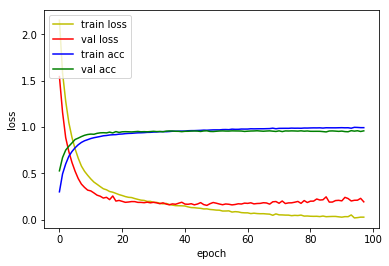

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2042 - acc: 0.9404
Loss: 0.2041721895723947 Accuracy: 0.9403946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7517 - acc: 0.4373
Epoch 00001: val_loss improved from inf to 0.99562, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_9_conv_checkpoint/001-0.9956.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.7517 - acc: 0.4373 - val_loss: 0.9956 - val_acc: 0.7226
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0208 - acc: 0.6857
Epoch 00002: val_loss improved from 0.99562 to 0.64536, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_9_conv_checkpoint/002-0.6454.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 1.0208 - acc: 0.6857 - val_loss: 0.6454 - val_acc: 0.8181
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1074 - acc: 0.9675
Epoch 00025: val_loss did not improve from 0.13554
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.1074 - acc: 0.9675 - val_loss: 0.1459 - val_acc: 0.9578
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0990 - acc: 0.9683
Epoch 00026: val_loss improved from 0.13554 to 0.12192, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_9_conv_checkpoint/026-0.1219.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0990 - acc: 0.9683 - val_loss: 0.1219 - val_acc: 0.9606
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0937 - acc: 0.9710
Epoch 00027: val_loss did not improve from 0.12192
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0937 - acc: 0.9710 - val_loss: 0.1624 - val_acc: 0.9502
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9920
Epoch 00054: val_loss did not improve from 0.12192
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0256 - acc: 0.9920 - val_loss: 0.1587 - val_acc: 0.9641
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9910
Epoch 00055: val_loss did not improve from 0.12192
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0277 - acc: 0.9910 - val_loss: 0.1917 - val_acc: 0.9578
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9930
Epoch 00056: val_loss did not improve from 0.12192
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0224 - acc: 0.9930 - val_loss: 0.1519 - val_acc: 0.9618
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9903
Epoch 00057: val_loss did not improve from 0.12192
36805/36805 [========================

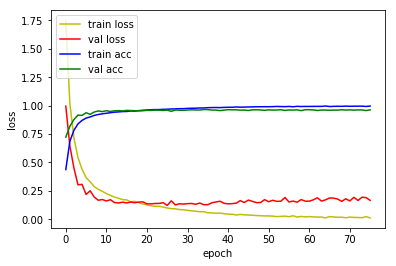

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1734 - acc: 0.9522
Loss: 0.17343066223778086 Accuracy: 0.9522326



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_92 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_93 (Conv1D)    

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.7363 - acc: 0.7848
Loss: 0.7362892188758493 Accuracy: 0.78483903

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_114 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_115 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_116 (Acti

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2361 - acc: 0.9304
Loss: 0.23610414765148519 Accuracy: 0.93042576

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_140 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_141 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_142 (Act

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1734 - acc: 0.9522
Loss: 0.17343066223778086 Accuracy: 0.9522326


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

with open(path.join(log_dir, base+'_last'), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_92 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_93 (Conv1D)    

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.8005 - acc: 0.8064
Loss: 0.8005038899548452 Accuracy: 0.8064382

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_114 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_115 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_116 (Activ

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2756 - acc: 0.9302
Loss: 0.2756348603796736 Accuracy: 0.93021804

1D_CNN_custom_conv_3_VGG_tanh_DO_075_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_140 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_141 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_142 (Acti

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2217 - acc: 0.9541
Loss: 0.22173708323742286 Accuracy: 0.95410174
